<a href="https://colab.research.google.com/github/ronglu-stanford/RL_reference_public/blob/main/Deep_Learning_for_NLP_(ICME_Summer_Workshop%2C_2021).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Natural Language Processing

*Instructor: Sam Gorman*

*Created By: Luke de Oliveira*

*Date: July 21, 2021*

## Structure

This notebook is split up into three parts. 

The first part is an introduction to "wrangling" text data in Python and how to prepare text data for use with Machine Learning algorithms. 

The second part walks through an implementation of a sentiment detection model with a Long Short-Term Memory network (LSTM). 

The third part will use a demo dataset to train a Semantic Chunking model for a conversational agent. 

To use a hardware accelerator (i.e., a GPU) navigate in the menu above to **`Runtime > Change runtime type > GPU`**.

## License

All code examples and code downloads are licensed under the (extremely permissive) [MIT license](https://opensource.org/licenses/MIT). My goal is to have this be a useful base for you, should you so desire.

## Datasets

This notebook will use two datasets: 

* A binary sentiment dataset, with reviews / produced content from Yelp, Amazon, and Twitter
* A semantic chunking dataset for a virtual assistant use case, where we'll be understanding weather queries

To download the sentiment dataset, run this cell:

In [ ]:
!wget -q https://ldo.io/icme-sws/2019/sentiment-data.json

To download the virtual assistant dataset, run this cell:

In [ ]:
!wget -q https://ldo.io/icme-sws/2019/weather-assistant.json

To download the `icmenlp` package, we run:

In [ ]:
!wget -q https://ldo.io/icme-sws/2019/icmenlp.py

Let's take a look in our VM's directory...

In [ ]:
ls

icmenlp.py  sample_data/  sentiment-data.json  weather-assistant.json


## Setup

We'll be using Colaboratory built-in libraries (scikit-learn & Keras) in order to avoid set up!

Let's set up our imports below.

In [ ]:
# Make sure if we change any imports, they're reflected in our notebook
%load_ext autoreload
%autoreload 2

In [ ]:
from tensorflow import keras
#Necessary in order to import sequence module 
#https://github.com/keras-team/keras/issues/8715
from keras.preprocessing import sequence

Now, we'll use our library for this tutorial - `icmenlp`. This library provides two main utilities -- first, a principled way to load the data for this session, and second, a vocabulary container, which we will describe later.

In [ ]:
import icmenlp
!cat icmenlp.py

"""
file: icmenlp.py
description: Utilities for the ICME summer workshop on Deep Learning for NLP
copyright: 2018 Luke de Oliveira, MIT Licensed.
date: August 17th, 2018
"""

import json

import keras
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split


def load_data(path, source='assistant', splits=(70, 10, 20)):
    """
    Loads data type specified from the file passed in.

    Args:
        path (Path): A path to a file (json) to load from.
        source (str): One of 'assistant' or 'sentiment'
        splits (tuple): A length-3 tuple containing the training split size,
            val split size, and testing split size respectively.

    Returns:
        Dict: A dictionary with keys 'train', 'val', and 'test', holding each
            respective set.

    Raises:
        ValueError: If you do not pass in a tuple of length three into splits.
    """
    if not len(splits) == 3:
        raise ValueError('splits expected

Let's open our datasets using data loading functions that will provide us with a train-test-validate split.

In [ ]:
ASSISTANT_DATA = 'weather-assistant.json'
SENTIMENT_DATA = 'sentiment-data.json'

In [ ]:
assistant_data = icmenlp.load_data(ASSISTANT_DATA, 'assistant')

In [ ]:
assistant_data['train'][4]

[{'text': 'Is it going to be '},
 {'label': 'condition_description', 'text': 'windy'},
 {'text': ' '},
 {'label': 'current_location', 'text': 'here'},
 {'text': ' on '},
 {'label': 'timeRange', 'text': 'Nov. 17'}]

In [ ]:
# Define a small utility to display chunked data a bit more easily
def display_chunking(chunks):
    sent = ''
    for ch in chunks:
        label = ch.get('label')
        text = ch['text']
        if not label:
            sent += text
        else:
            sent += '[{} | {}]'.format(text, label.upper())
    return sent

In [ ]:
display_chunking(assistant_data['train'][4])

'Is it going to be [windy | CONDITION_DESCRIPTION] [here | CURRENT_LOCATION] on [Nov. 17 | TIMERANGE]'

## Data Exploration and Visualization
You'll save yourself from future headaches in more complex deep learning specific tasks later in the pipeline by taking the time to understand your data. Like classical ML methods, deep learning models can only perform to the level of quality of data you provide.  Poor labeling, statistical bias, overlap in train / val / test sets and more can negatively affect performance of deep learning models. Here, we provide some cursory scaffolding for data exploration.

[Pandas](https://pandas.pydata.org/docs/reference/index.html#api) is a popular library that provides high-level building blocks for data in Python with the notion of a dataframe object. In practice in deep learning, we use tensors with libraries such as Tensorflow or Pytorch, but rapid data exploration in Pandas remains a helpful preliminary step before proceeding further.

In [ ]:
import pandas as pd 

sentiment_data = icmenlp.load_data(SENTIMENT_DATA, 'sentiment')

train_df = pd.DataFrame.from_dict(sentiment_data['train'])
train_df = train_df.transpose()
train_df.columns = ['text','label']

test_df = pd.DataFrame.from_dict(sentiment_data['test'])
test_df = test_df.transpose()
test_df.columns = ['text','label']


test_df.info() #Provides a useful summary of the dataframe
#Note there are several other helpful Pandas methods for data exploration
#test_df.head() #This method provides a snapshot of the top n elements in the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    300 non-null    object
 1   label   300 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [ ]:
#Helper function to randomly sample 10 text,label pairs 
def display_positives_negatives(train_or_test_dict):
   sample = train_or_test_dict.sample(10)
   return sample


display(display_positives_negatives(test_df))


,text,label
98,"i saw it as a child on tv back in 1973, when i...",positive
68,the food was outstanding and the prices were v...,positive
119,"it's a sad movie, but very good.",positive
224,i cannot believe that the actors agreed to do ...,negative
201,worked perfectly!,positive
27,"if you don't find it, too bad, as again the un...",negative
184,very slow at seating even with reservation.,negative
176,"during several different 2 minute calls, i exp...",negative
260,"it lasts less than 3o minutes, if i actually t...",negative
292,"yes, i am simplifying things here for the sake...",negative


The graphical libary [Seaborn](https://seaborn.pydata.org/) is an easy-to-use wrapper for Matplot.lib. You can easily create visualizations for viewing label distributions, most common / uncommon tokens or ngrams, discrepencies in train/test data, and more.    Here, we use Seaborn (often abbreviated as sns in code) to observe that the distribution of the labels in our test set is roughly equivalent before proceeding further.

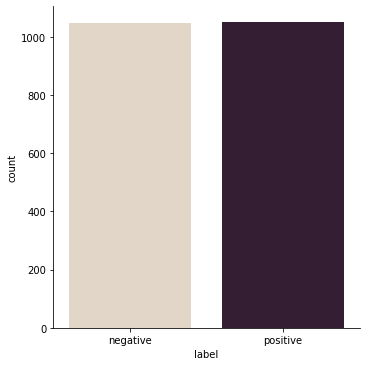

In [ ]:
import seaborn as sns 
g = sns.catplot(x="label", kind="count", palette="ch:.25", data=train_df)



# Manipulating Text Data for ML

One of the most asked questions both from students and from industry concerns how to prepare text data for deep learning. Today, we're going to focus on **embeddings** (one of the more popular incarnations of this is Word2Vec). Right now, we'll learn how to prepare data for usage in a model that learns to embed text.

The first step of any such pipeline is **tokenization**, that is, converting a single text or document into a *sequence* of *tokens*. For word level models, these tokens roughly correspond to words / contractions, and in a character model, this corresponds to individual bytes. Many modern methods use **subword** information, which allows you to make predictions over text that has words that were not trained on (the so-called OOV, or out of vocabulary, problem).

For example, the sentence
    
    Is there a minimum balance I need to maintain in my accounts?
    
could be *tokenized* as:
    
    'Is', 'there', 'a', 'minimum', 'balance', 'I', 'need', 'to', 'maintain', 'in', 'my', 'accounts', '?'

How can one systematically convert text into these *tokens* then? It turns out this is one of the most critical,  important, and underappreciated steps. It drastically differs from language to language, and requires a lot of care to ensure consistency. This is one of the reasons why **character level** or **subword** models can be so useful in applied settings with inconsistent spelling, grammar, and nomenclature.

The dominant approach to doing word-based tokenization consists of using a [**regular expression**](https://en.wikipedia.org/wiki/Regular_expression). Regular expressions define a formal language for searching through strings for matches to a query. We'll use one here to work with our text in this tutorial 

In [ ]:
# Re is the Python RegEx library
import re

def tokenize(text):
    return [
        # Make sure there is no trailing whitespace
        x.strip() 
        # Split the text on matches of at least one "word"
        for x in re.split('(\W+)', text)     # match on non-alpha / non-numeric characters
                                             # will also return the splitting chars
        # Only include the token if it is not null
        if x.strip() 
    ]

Let's load the sentiment dataset to try this out!

In [ ]:
sentiment_data = icmenlp.load_data(SENTIMENT_DATA, 'sentiment')

# Let's grab out a random training point
# 0 is text (1 is labels)
# (2 is a specific element)
text = sentiment_data['train'][0][2]

In [ ]:
print(text)

i have 2-3 bars on my cell phone when i am home, but you cant not hear anything.


In [ ]:
print(tokenize(text))

['i', 'have', '2', '-', '3', 'bars', 'on', 'my', 'cell', 'phone', 'when', 'i', 'am', 'home', ',', 'but', 'you', 'cant', 'not', 'hear', 'anything', '.']


In [ ]:
#Let's take a look at our labels!
print(sentiment_data['train'][1][2])

negative


We will get into more detail about how embedding models work later on, but for now, let's discuss the conversion of text into a format that is useful for embedding models. Embedding models rely on an **integer** representation for each word, since we will use it as lookup into a **lookup table**.

An important consideration when using deep learning models is the length of a piece of text, as well as a signal of the beginning and end of a sentence. Most deep learning models require that each batch of text passed in to the model have identical sentence lengths. We commonly solve this using **padding**, or adding a series of meaningless tokens to increase the length of a document. We can then use **masking** to ensure that our model does not incorporate these into the learning procedure.

We'll use `<PAD>` as the pad token, and `<S>`/`</S>` to delimit the beginning of a sentence and the end of a sentence respectively. In addition, any tokens that are unknown to us (for example, a word that is in the test set but not the train set) are mapped to the `<UNK>` token.

To map from tokens to integers, we will define a bijective (two-way) map from words to integers. This mapping is generated by considering all tokens in all documents and then assigning integers (up to MAX_VOCAB). Later the model will learn a vector representations for each element of the vocab (n-dimensional vectors where each entry is a float).

We're going to use the one from our `icmenlp` package.

In [ ]:
# Let's look inside the code of the utility provxided
#You can use the ?? to open the referenced code from another file
icmenlp.VocabularyContainer??

In [ ]:
# Create a vocab collection object with the tokenizer we defined above
vocab = icmenlp.VocabularyContainer(tokenizer=tokenize)

In [ ]:
text = sentiment_data['train'][0]

In [ ]:
vocab.fit(text)

In [ ]:
vocab.transform(['this product was bad!'])

[[3178, 1528, 3394, 3525, 3049]]

In [ ]:
#getting an err here

vocab.transform(['this product was bad!', 'meh'], pad_length=10)

[[0, 0, 0, 0, 0, 3178, 1528, 3394, 3525, 3049],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1345]]

In [ ]:
vocab.transform(['this product was bad!'])

[[3178, 1528, 3394, 3525, 3049]]

In [ ]:
vocab.transform(['this product was abhorrent!'])

[[3178, 1528, 3394, 1, 3049]]

In [ ]:
vocab.inverse_transform(vocab.transform(['this product was abhorrent!']))

[['this', 'product', 'was', '<UNK>', '!']]

In [ ]:
vocab.inverse_transform(
    vocab.transform(
        ['this product was abhorrent!'], 
        pad_length=9, 
        add_start=True, 
        add_end=True
    )
)

[['<PAD>', '<PAD>', '<S>', 'this', 'product', 'was', '<UNK>', '!', '</S>']]

We now know how to preprocess text data for use in deep learning. To summarize:

1.) Each document gets split into tokens, a process called tokenization.

2.) A mapping is created from the vocabulary to unique integers.

3.) We have four special tokens -- the pad token `<PAD>`, the start-of-sentence token `<S>`, the end-of-sentence token `</S>`and the unknown token `<UNK>`.

4.) We pad sentences with the `<PAD>` token to make them the same size.

Now, let's learn about deep learning for NLP!

# Sentiment Analysis

For the next segment, we're going to train a sentiment prediction model using deep learning. In particular, we're going to use a recurrent neural network (RNN) to process text **token by token**. We'll be using words as tokens.

An RNN uses a **cell** to process each timestep of s sequence. In this case, the cell of our RNN will process text one word at a time. A common problem with RNNs is that early timesteps are forgotten, and our network has no signal related to early timesteps. A Long short-term memory (LSTM) network solves this by introducing a better method for retaining state/memory via a **memory cell**, and introducing a **forget gate**, which allows the network to learn when to forget.

Let's walk through how to build a model for our sentiment analysis task. 

*Best-practice tip*: we're going to create and use a **new class** to make sure we can keep track of the preprocessing that goes into such a model.

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder


class BinarySentimentModel():

    def __init__(self, embedding_dim=128, lstm_size=256, bidirectional=False,
                 optimizer='adam'):
        """Create a new model to handle a binary sentiment task.

        The wrapper class will hold all state with respect to preprocessing,
        transformation, and model training.

        Args:
            embedding_dim (int): The dimension of the "word vectors" to be
                trained in the model.
            lstm_size (int): The number of hidden units in the LSTM.
            bidirectional (bool): Whether or not to process the data using a
                bidirectional or single-directional LSTM.
            optimizer (str | keras.optimizers.Optimizer): The optimizer to use
                when optimizing the loss on the training set using Stochastic
                Gradient Descent (SGD).
        """
        # We need to convert the names of labels to integers for our model
        self.labelencoder = LabelEncoder()

        # We're going to use our vocab container from before to store all the
        # token -> ID mappings
        self.vocab = icmenlp.VocabularyContainer(tokenizer=tokenize)
        self.model = None

        # We're storing *hyperparameters* of the model here
        self.embedding_dim = embedding_dim
        self.lstm_size = lstm_size
        self.bidirectional = bidirectional
        self.optimizer = optimizer

    def make_model(self, vocab_size,shouldVisualize):
        """Creates a new keras model for the class.

        Args:
            vocab_size (int): The number of unique tokens contained in the
                training vocabulary

        Returns:
            keras.models.Model: A built and compiled Keras model for thre task.
        """

        #To use the Keras functional API, we define the shape of our inputs
        # The None tells Keras that we can expect differing sentence lengths
        text = keras.Input(shape=(None, ), dtype='int32')
        
        # We're going to learn word vectors. Since our sentences
        # will be padded, we tell Keras to mask everywhere it finds a zero
        embedding = keras.layers.Embedding(input_dim=vocab_size,
                                           output_dim=self.embedding_dim,
                                           mask_zero=True)
        embedded_text = embedding(text)

        # An RNN needs to take a Cell as an input. This is the diagram
        # from lecture of the LSTM.
        lstm = keras.layers.RNN(
            cell=keras.layers.LSTMCell(units=self.lstm_size)
        )

        if self.bidirectional:
            # We can process both directions
            lstm = keras.layers.Bidirectional(lstm)

        # Keras will, by default, return us the state after processing the
        # entire document (not the state for evert element in the input seq.)
        h = lstm(embedded_text)

        # We will use dropout to regularize our model while passing it through
        # a single fully connected layer.
        h = keras.layers.Dropout(0.5)(h)
        h = keras.layers.Dense(self.lstm_size // 2, activation='relu')(h)
        h = keras.layers.Dropout(0.5)(h)

        # This is a binary problem, so we have a single output
        output = keras.layers.Dense(1, activation='sigmoid')(h)

      
        model = keras.Model(text, output)
        if shouldVisualize:
            # print("this is our model summary")
            # print(model.summary())
            keras.utils.plot_model(model, "bc_withshapes.png", show_shapes=True)

        # We're going to use crossentropy as our loss function here
        model.compile(optimizer=self.optimizer,
                      loss='binary_crossentropy',
                      metrics=['acc'])
        return model

    def fit(self, documents, labels, validation_data=None, pad_length='max',
            **kwargs):
        """Trains (or fits) the model on training data while validating
        on validation data

        Args:
            documents (List[str]): A list of training documents
            labels (List[str | int]): A list of training labels associated to
                each document.
            validation_data (Tuple[List[str], List[str]]): A tuple of
                validation data of the form (val_documents, val_labels)
            pad_length (str | int): The padding length to use for training.
            **kwargs: Passed to keras.Model.fit

        Returns:
            self

        Raises:
            ValueError: If validation data is not of the correct format.
        """
        #In order for us to call .fit, we need to define both an X and Y, 
        #where X is input data and y is our target data.

        # X will be an array of integers corresponding to words
        X = np.array(
            self.vocab.fit(documents).transform(
                documents, pad_length=pad_length)
        )

        # y will be an array of integers corresponding to sentiment labels (0
        # or 1)
        y = self.labelencoder.fit_transform(labels)

        if validation_data:
            # Process validation data the same way we process our training data
            if not len(validation_data) == 2:
                raise ValueError('Validation data must be a tuple (X, y)')
            documents_val, labels_val = validation_data
            validation_data = (
                np.array(self.vocab.transform(
                    documents_val, pad_length=pad_length)),
                self.labelencoder.transform(labels_val)
            )
            _ = kwargs.pop('validation_data', None)

        # Construct our Keras model
        self.model = self.make_model(vocab_size=self.vocab.vocab_size)

        # In practice, we would set up a *callback* in order to stop
        # training when the validation error is minimized
        self.model.fit(X, y, validation_data=validation_data, **kwargs)
        return self

    def predict_proba(self, documents, pad_length='max', **kwargs):
        # To run a prediction, we have to run all the way from:
        # text -> tokenization -> integers -> model
        # Here, we only care to get the probabilities for each class
        indices = np.array(self.vocab.transform(
            documents, pad_length=pad_length))
        return self.model.predict(indices, **kwargs).ravel()

    def predict(self, documents, pad_length='max', **kwargs):
        # We can use the above method to get probabilities per class, then
        # we just take the most likely one and recover the label
        label_inv = self.predict_proba(documents, pad_length=pad_length,
                                       **kwargs)
        return self.labelencoder.inverse_transform(1 * (label_inv > 0.5))


In [ ]:
sentiment_model = BinarySentimentModel(bidirectional=True)

Here, we pass the param shouldVisualize into make_model in order to 1. Display a summary of the model layers and 2. Download a png of the model graph with keras.utils.plot_model. Note that this implementation is for instructional purposeses of visualizing our model, and it's advisable to remove code like this before production. However, .summary() remains a powerful tool for debugging models in development.

In [ ]:
sentiment_model.make_model(60,shouldVisualize=True)

In [ ]:
text, labels = sentiment_data['train']

In [ ]:
text[:5], labels[:5]

(['there is simply no excuse for something this poorly done.',
  'they were excellent.',
  'i have 2-3 bars on my cell phone when i am home, but you cant not hear anything.',
  'there is nothing authentic about this place.',
  'good prices.'],
 ['negative', 'positive', 'negative', 'negative', 'positive'])

In [ ]:
# In a real application, we would use a EarlyStopping and ModelCheckpoint 
# callback to stop training at the bottom of the validation loss curve.
sentiment_model.fit(
    *sentiment_data['train'],               # unpacks the tuple to docs and labels
    validation_data=sentiment_data['val'], 
    epochs=3
)

Epoch 1/3
66/66 [==============================] - 34s 432ms/step - loss: 0.6511 - acc: 0.6190 - val_loss: 0.6572 - val_acc: 0.7650
Epoch 2/3
66/66 [==============================] - 29s 442ms/step - loss: 0.3298 - acc: 0.8776 - val_loss: 0.3630 - val_acc: 0.8500
Epoch 3/3
66/66 [==============================] - 30s 449ms/step - loss: 0.1742 - acc: 0.9533 - val_loss: 0.4283 - val_acc: 0.8283


In [ ]:
sentiment_model.predict([
    'this was the worst product ive ever used!!!', 
    'pretty awesome product!!!'
]) 

array(['negative', 'positive'], dtype='<U8')

In [ ]:
sentiment_model.predict_proba([
    'this was the worst product ive ever used!!!', 
    'this was the best product ive ever used!!!'
])

array([0.12760785, 0.9930373 ], dtype=float32)

# Virtual Assistant Dataset

In this example, we're going to train a model that is able to peform query understanding on a dataset of weather requests to a virtual assistant. We're going to build an LSTM model to predict what recognized component of a query each word in a piece of dialog corresponds to.

In [ ]:
# Let's get an example to understand
example = assistant_data['train'][60]

In [ ]:
print(example)

[{'text': 'Where is '}, {'text': 'Bernardsville', 'label': 'city'}, {'text': '?'}]


How can entities be encoded into labels? There is much debate on this, but there are generally three approaches:

* **IO-encoding**: Only encodes that a token is an entity of a given type or not
* **BIO-encoding**: Encodes the begining of an entity with a `B`, and also any following tokens in an entity with an `I`
* **BILUO-encoding**: Encodes the begining of an entity with a `B`, any following tokens in an entity with an `I`, and the last token of an entity with a `L`. Single token entities are a `U`

For example:

*How cold is it tomorrow evening?*

IO:
*How cold [`TEMP`] is it tomorrow [`TIME`] evening [`TIME`]?*

BIO:
*How cold [`B-TEMP`] is it tomorrow [`B-TIME`] evening [`I-TIME`]?*

BILUO:
*How cold [`U-TEMP`] is it tomorrow [`B-TIME`] evening [`L-TIME`]?*

In [ ]:
def get_word_labels(example, tokenizer=tokenize):
    """
    We define a function that can take this data, and 
    return a sequence of tokens and a sequence of token-labels.
    """
    tokenized_text = []
    labels = []
    for chunk in example:
        tokenized_chunk_text = tokenize(chunk['text'])
        if 'label' in chunk:
            # We're doing a subobtimal thing jere
            chunk_labels = [chunk['label'].upper()] * len(tokenized_chunk_text)
        else:
            chunk_labels = ['-'] * len(tokenized_chunk_text)
        tokenized_text.extend(tokenized_chunk_text)
        labels.extend(chunk_labels)
    return tokenized_text, labels

In [ ]:
example

[{'text': 'Where is '},
 {'label': 'city', 'text': 'Bernardsville'},
 {'text': '?'}]

In [ ]:
get_word_labels(example)

(['Where', 'is', 'Bernardsville', '?'], ['-', '-', 'CITY', '-'])

In [ ]:

class WeatherAssistantModel():

    def __init__(self, embedding_dim=128, lstm_size=256, optimizer='adam'):
        """Create a new model to handle a weather assistant use case.

        The wrapper class will hold all state with respect to preprocessing,
        transformation, and model training.

        Args:
            embedding_dim (int): The dimension of the "word vectors" to be
                trained in the model.
            lstm_size (int): The number of hidden units in the LSTM.
            optimizer (str | keras.optimizers.Optimizer): The optimizer to use
                when optimizing the loss on the training set using Stochastic
                Gradient Descent (SGD).
        """
        # We encode the label space and the vocabulary as `VocabularyContainer`
        # for padding. Our text is pretokenized, so we don't need a tokenizer
        self.labelencoder = icmenlp.VocabularyContainer(tokenizer=lambda x: x)
        self.vocab = icmenlp.VocabularyContainer(tokenizer=lambda x: x)
        self.model = None

        # Store our hyperparameters
        self.embedding_dim = embedding_dim
        self.lstm_size = lstm_size
        self.optimizer = optimizer

    def make_model(self, nb_classes, vocab_size):
        """Creates a new keras model for the class.

        Args:
            nb_classes (int): The total number of entity classes to predict
            vocab_size (int): The number of unique tokens contained in the
                training vocabulary

        Returns:
            keras.models.Model: A built and compiled Keras model for the task.
        """

        # The None tells Keras that we can expect differing sentence lengths
        text = keras.Input(shape=(None, ), dtype='int32')
        
        # will be padded, we tell Keras to mask all tensor values equal to zero
        embedding = keras.layers.Embedding(input_dim=vocab_size,
                                           output_dim=self.embedding_dim,
                                           mask_zero=True)
        embedded_text = embedding(text)

        # We use a bi-LSTM, but this time, we return the sequences per-token
        # with the return_sequences argument (one value of the hidden state per
        # input token)
        bilstm = keras.layers.Bidirectional(
            keras.layers.RNN(
                keras.layers.LSTMCell(self.lstm_size),
                return_sequences=True
            )
        )
        h = bilstm(embedded_text)

        # Output the distribution of entites per timestep
        output = keras.layers.Dense(nb_classes, activation='softmax')(h)

        model = keras.Model(text, output)
        model.compile(optimizer=self.optimizer,
                      loss='sparse_categorical_crossentropy')

        return model

    def fit(self, chunked_documents, validation_data=None, **kwargs):
        """Trains (or fits) the model on training data while validating
        on validation data

        Args:
            chunked_documents (List[List[Dict]]): Training data
            validation_data (List[List[Dict]]): Validation data
            **kwargs: Passed to keras.Model.fit

        Returns:
            self
        """
        # Get paired pre-tokenized documents with per-token tags
        documents, labels = zip(*[
            get_word_labels(example, tokenizer=tokenize)
            for example in chunked_documents
        ])

        # We want our input documents and our output labels to be integers
        X = np.array(self.vocab.fit(documents).transform(
            documents, pad_length=30))
        Y = np.expand_dims(
            np.array(self.labelencoder.fit(
                labels).transform(labels, pad_length=30)),
            -1
        )

        nb_classes = self.labelencoder.vocab_size

        if validation_data:
            # Process validation data identically to training data
            documents_val, labels_val = zip(*[
                get_word_labels(example, tokenizer=tokenize)
                for example in validation_data
            ])
            validation_data = (
                np.array(self.vocab.transform(documents_val, pad_length=30)),
                np.expand_dims(np.array(self.labelencoder.transform(
                    labels_val, pad_length=30)), -1)
            )
            _ = kwargs.pop('validation_data', None)

        self.model = self.make_model(nb_classes=nb_classes,
                                     vocab_size=self.vocab.vocab_size)

        # In practice, we would set up a callback in order to stop
        # training when the validation error is minimized
        self.model.fit(X, Y, validation_data=validation_data, **kwargs)

        return self

    def predict(self, document):
        # To run inference on a single document, we tokenize it, obtain indices
        # run it though the model, then decode the most likely tags per token.
        segments, _ = get_word_labels([{'text': document}], tokenizer=tokenize)
        indices = np.array(self.vocab.transform(segments))
        label_inv = self.model.predict(indices).argmax(-1).astype(int).tolist()
        return list(zip(
            segments, self.labelencoder.inverse_transform(label_inv)
        ))


In [ ]:
assistant_model = WeatherAssistantModel(lstm_size=256, embedding_dim=64)

In [ ]:
# In a real application, we would use a EarlyStopping and ModelCheckpoint 
# callback to stop training at the bottom of the validation loss curve.
assistant_model.fit(assistant_data['train'], assistant_data['val'], 
                    epochs=20, batch_size=32)

Epoch 1/20
44/44 [==============================] - 7s 157ms/step - loss: 0.5884 - val_loss: 0.4196
Epoch 2/20
44/44 [==============================] - 7s 149ms/step - loss: 0.3960 - val_loss: 0.3291
Epoch 3/20
44/44 [==============================] - 7s 149ms/step - loss: 0.2910 - val_loss: 0.2292
Epoch 4/20
44/44 [==============================] - 7s 149ms/step - loss: 0.2000 - val_loss: 0.1577
Epoch 5/20
44/44 [==============================] - 7s 152ms/step - loss: 0.1208 - val_loss: 0.1066
Epoch 6/20
44/44 [==============================] - 7s 153ms/step - loss: 0.0765 - val_loss: 0.0844
Epoch 7/20
44/44 [==============================] - 7s 152ms/step - loss: 0.0539 - val_loss: 0.0730
Epoch 8/20
44/44 [==============================] - 7s 153ms/step - loss: 0.0372 - val_loss: 0.0726
Epoch 9/20
44/44 [==============================] - 7s 150ms/step - loss: 0.0240 - val_loss: 0.0621
Epoch 10/20
44/44 [==============================] - 7s 149ms/step - loss: 0.0147 - val_loss: 0.0573

In [ ]:
result = assistant_model.predict("How cold is it tomorrow?")

In [ ]:
result

[('How', ['-']),
 ('cold', ['CONDITION_TEMPERATURE']),
 ('is', ['-']),
 ('it', ['-']),
 ('tomorrow', ['TIMERANGE']),
 ('?', ['-'])]

In [ ]:
understood_entities = [
    (word, ent_type[0])
    for word, ent_type in result
    if ent_type[0] != '-'
]

In [ ]:
understood_entities

[('cold', 'CONDITION_TEMPERATURE'), ('tomorrow', 'TIMERANGE')]